In [2]:
import sys

import pandas 
import numpy

import matplotlib.pyplot
import seaborn

import networkx

from scipy.stats import ranksums

sys.path.append("../scripts")
from utils import parse_interactome

In [44]:
def parse_scores(scores_file):
    # load scores
    scores = {}

    with open(scores_file, 'r') as f:
        # skip header
        next(f)

        data = f.read().splitlines()
        for line in data:
            line_splitted = line.split('\t')
            ENSG, gene, score = line_splitted
            scores[ENSG] = float(score)

    return scores

In [45]:
def parse_leave_one_out(scores_file):
    # load left-out scores
    scores_left_out = {}

    with open(scores_file, 'r') as f:
        # skip header
        next(f)

        data = f.read().splitlines()
        for line in data:
            line_splitted = line.split('\t')
            ENSG, gene, score = line_splitted
            scores_left_out[ENSG] = float(score)
        
    return scores_left_out

In [38]:
def concatenate_scores(scores, scores_left_out):
    df_scores = pandas.DataFrame.from_dict(scores, 
                                       orient='index', 
                                       columns=['score'])
    df_scores['group'] = "non-causal"

    df_scores_left_out = pandas.DataFrame.from_dict(scores_left_out, 
                                                    orient='index', 
                                                    columns=['score'])

    df_scores_left_out['group'] = 'left-out'

    # concatenate dataframes for comparison
    df_compare = pandas.concat([df_scores, df_scores_left_out])

    stat, p_value = ranksums(df_scores['score'].values, df_scores_left_out['score'].values)

    return df_compare, p_value

In [8]:
def causal_genes_at_distance(dict_distances, node, d):
    try:
        return len([dist for dist in dict_distances.get(node).values() if dist == d])
    except:
        return 0

In [9]:
def geneName_to_ENSG(genes_file):
    genes = {}

    f = open(genes_file, 'r')
    
    # skip header
    next(f)

    for line in f:
        line_splitted = line.rstrip().split('\t')
        gene_name, ENSG = line_splitted

        genes[gene_name] = ENSG
    
    return genes

#### Set parameters

In [39]:
PHENOTYPE = "MMAF"
ALPHA = 0.5
D_MAX = 10
ALPHA_NORM = 1

#### Load the necessary data

In [54]:
interactome = parse_interactome(interactome_file="/home/kubicaj/calc/input/Interactome_human.sif")

alpha = str(ALPHA).replace('.', '')
scores = parse_scores(f"/home/kubicaj/calc/output/New_centrality_v6/alpha{alpha}_dmax{D_MAX}_alphanorm_{ALPHA_NORM}/scores.tsv")
scores_leave_one_out = parse_leave_one_out(f"/home/kubicaj/calc/output/New_centrality_v6/alpha{alpha}_dmax{D_MAX}_alphanorm_{ALPHA_NORM}/scores_leave_one_out.tsv")

#### Analyze leave-one-out results: newCentrality.py

In [55]:
df_compare, p_value = concatenate_scores(scores, scores_leave_one_out)

Text(0.5, 1.0, 'Compare non-causal genes scores (all MMAF genes used)\n with scores for MMAF genes (leave-one-out)\nalpha=0.5,   d=10,    alpha_norm=1')

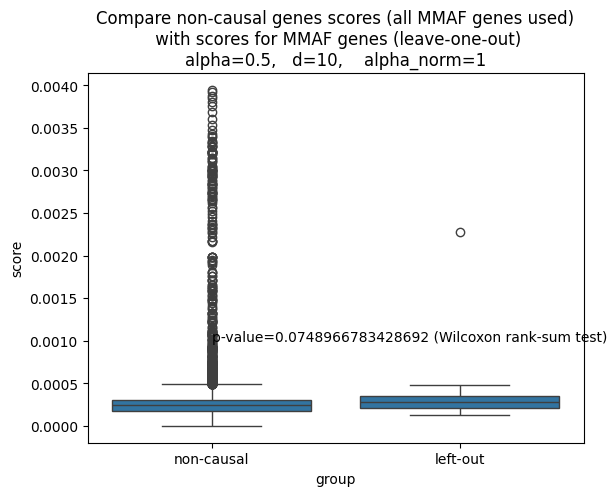

In [56]:
# plot
seaborn.boxplot(data=df_compare, x='group', y='score')
matplotlib.pyplot.text(0, 0.001, s=f"p-value={p_value} (Wilcoxon rank-sum test)")
matplotlib.pyplot.title(f"Compare non-causal genes scores (all {PHENOTYPE} genes used)\n with scores for {PHENOTYPE} genes (leave-one-out)\nalpha={ALPHA},   d={D_MAX},    alpha_norm={ALPHA_NORM}")

In [57]:
# top 10 high-scoring genes
scores_sorted = {node: score for node, score in sorted(scores.items(), key=lambda item: item[1], reverse=True)}
scores_sorted

{'ENSG00000219481': 0.003944438801877314,
 'ENSG00000071677': 0.003921356714890362,
 'ENSG00000146090': 0.0038706112241273195,
 'ENSG00000248099': 0.0038518074177324125,
 'ENSG00000133105': 0.0038019442611861875,
 'ENSG00000196118': 0.003752424286496818,
 'ENSG00000145740': 0.003690177193133991,
 'ENSG00000124935': 0.0035991583970926043,
 'ENSG00000155858': 0.0035354474141939362,
 'ENSG00000101441': 0.003469973313738673,
 'ENSG00000176371': 0.0034228437603960895,
 'ENSG00000152034': 0.0034085383479477514,
 'ENSG00000140104': 0.0033906761468040824,
 'ENSG00000111962': 0.003346173030691573,
 'ENSG00000149972': 0.0033341716979004045,
 'ENSG00000099834': 0.0033267333722960305,
 'ENSG00000181523': 0.003316830036769947,
 'ENSG00000171488': 0.0032913078308201733,
 'ENSG00000197147': 0.0032913078308201733,
 'ENSG00000164076': 0.0032869481209466286,
 'ENSG00000187193': 0.003271427201304996,
 'ENSG00000132465': 0.0032308484167908155,
 'ENSG00000119004': 0.0032172281663760695,
 'ENSG00000204640':

#### Scores analysis newCentrality_v4 more info

In [58]:
# find distances between MMAF and non-MMAF genes
dict_distances = {}
longest_distance = 0

nonCausal_genes_list = [k for k, v in causal_genes.items() if v == 0]
causal_genes_list = [k for k, v in causal_genes.items() if v == 1]

for source_node in nonCausal_genes_list:
    dict_tmp = {}

    for target_node in causal_genes_list:
        try:
            distance = networkx.shortest_path_length(interactome, source_node, target_node)
            dict_tmp[target_node] = distance

            if distance > longest_distance:
                longest_distance = distance
        except:
            continue

    dict_distances[source_node] = dict_tmp

print(f"Longest distance between {PHENOTYPE} and non-{PHENOTYPE} gene: {longest_distance}")

NameError: name 'causal_genes' is not defined

In [28]:
# get more info about each node (degree, causal genes at distances)
for n, score in scores_sorted.items():
    scores_sorted[n] = [score, 
                        interactome.degree(n), 
                        (n in causal_genes_list),
                        causal_genes_at_distance(dict_distances, n, 1), 
                        causal_genes_at_distance(dict_distances, n, 2),
                        causal_genes_at_distance(dict_distances, n, 3),
                        causal_genes_at_distance(dict_distances, n, 4)]

df = pandas.DataFrame.from_dict(scores_sorted, 
                                orient='index', 
                                columns=['score', 'degree', 'isCausal', 'causal genes at d=1', 'causal genes at d=2', 'causal genes at d=3', 'causal genes at d=4'])

NameError: name 'causal_genes_list' is not defined

Text(0.5, 1.0, 'New centrality v4 scores vs. node degree')

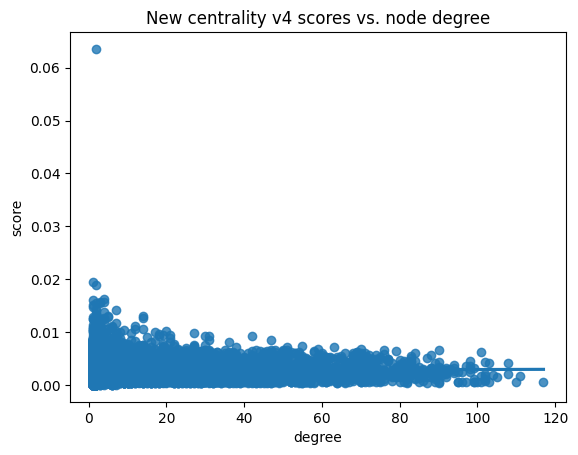

In [43]:
seaborn.regplot(data=df, x="degree", y="score")
matplotlib.pyplot.title("New centrality scores vs. node degree")

#### Analyze new candidates from 13/02/2024

In [93]:
genes = geneName_to_ENSG("/home/kubicaj/calc/input/canonicalGenes.tsv")

In [94]:
new_candidates_names = ['CLHC1', 'PHF20', 'NUSAP1', 'CDC20B', 'FAM221A', 'GALR3', 'LRRC9', 'KIF27', 'ZNF208', 'C6orf118', 'CCDC66', 'CCNA1', 'DDX43', 'FSCB', 'FHAD1', 'LRGUK', 'MYCBPAP', 'MYH7B', 'PCDHB15', 'SAMD15', 'SPACA9', 'SPATA24', 'SPATA6', 'TSSK4', 'TTLL2']
new_candidates_ENSG = [genes.get(n) for n in new_candidates_names]
new_candidates = [n for n in new_candidates_ENSG if n in interactome]

In [95]:
# check scores of new candidates
scores_new_candidates = {n: scores.get(n) for n in new_candidates}

In [96]:
scores_new_candidates

{'ENSG00000162994': 0.007260260159322377,
 'ENSG00000025293': 0.001894209422164287,
 'ENSG00000164287': 0.005825827457693127,
 'ENSG00000188732': 0.004685429254192363,
 'ENSG00000128310': 0.0012217470983506415,
 'ENSG00000165115': 0.0052604394294568715,
 'ENSG00000180376': 0.019418580591764947,
 'ENSG00000133101': 0.002870723384191137,
 'ENSG00000080007': 0.0,
 'ENSG00000142621': 0.004924446842957367,
 'ENSG00000136449': 0.002955694144769899,
 'ENSG00000078814': 0.003450593054014848,
 'ENSG00000165698': 0.002766139750777555,
 'ENSG00000170469': 0.004178017602682313,
 'ENSG00000132122': 0.0041631074667645256,
 'ENSG00000139908': 0.001960179039975305,
 'ENSG00000120440': 0.00048473097430925833}

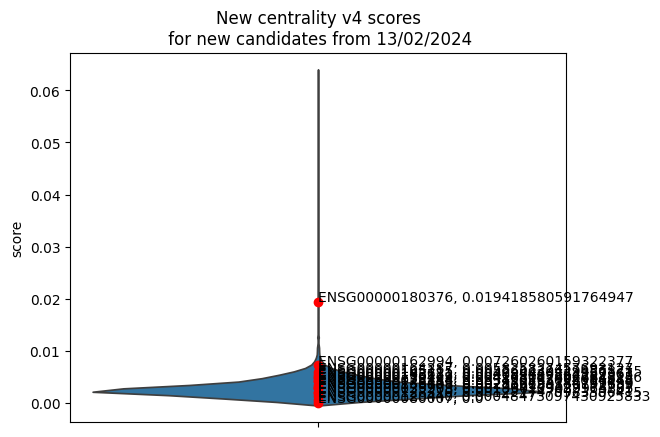

In [97]:
seaborn.violinplot(data=df, y='score')
matplotlib.pyplot.title("New centrality scores\n for new candidates from 13/02/2024")

for canidate, score in scores_new_candidates.items():
    matplotlib.pyplot.plot(score, 'or')
    matplotlib.pyplot.text(0, score, s=f"{canidate}, {score}")